# Testing `dda_atl` functionality

This includes testing the workflow for dda_atl, as well as the functionality of the `dda.steps` modules.

In [1]:
# initial imports
import eeasm_icesat.dda as dda
import eeasm_icesat.atl09 as atl

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmcrameri.cm as cm

In [2]:
#fname_atl = '/gws/nopw/j04/ncas_radar_vol1/eeasm/paper1/atl09/summit/processed_ATL09_20201120172445_08790901_005_01.h5'
fname_atl = '/gws/nopw/j04/ncas_radar_vol1/eeasm/paper1/atl09/summit/processed_ATL09_20210211004659_07491001_005_01.h5'

data_high, data_low = atl.load_xarray_from_ATL09.load_xarray_from_ATL09(fname_atl, subsetVariables=atl.load_xarray_from_ATL09.SUBSET_DEFAULT, get_low_rate=True, subsetVariables_low=atl.load_xarray_from_ATL09.SUBSET_LOW_CAL)

data_atl = atl.add_coordinates.add_coordinates(data_high)
data_atl = atl.interp_low_to_high(data_low,data_atl)

del data_high, data_low
data_atl

Frozen({'profile': 3, 'time_index': 1781, 'height': 700, 'layer': 10, 'surface type': 5})


/home/users/eeasm/_scripts/ICESat2/src/eeasm_icesat/atl09/load_xarray_from_ATL09.py:137: RuntimeWarning: invalid value encountered in multiply
  padding_nan = np.empty(padding_shape) * np.nan


Frozen({'profile': 3, 'time_index': 70, 'height': 700, 'layer': 10, 'surface type': 5})
{'profile': array([1, 2, 3]), 'time_index': array([   0,    1,    2, ..., 1778, 1779, 1780])}


<xarray.Dataset>
Dimensions:         (profile: 3, time_index: 1781, height: 700, layer: 10,
                     surface type: 5)
Coordinates:
  * profile         (profile) int64 1 2 3
  * time_index      (time_index) int64 0 1 2 3 4 5 ... 1776 1777 1778 1779 1780
  * height          (height) float32 2e+04 1.997e+04 1.994e+04 ... -925.5 -955.5
  * layer           (layer) int64 0 1 2 3 4 5 6 7 8 9
  * surface type    (surface type) int64 0 1 2 3 4
    d2s             (profile, time_index) float64 312.5 312.2 ... 243.3 243.6
    height_AGL      (profile, time_index, height) float64 1.691e+04 ... -3.89...
    time            (profile, time_index) datetime64[ns] 2021-02-11T01:05:14 ...
Data variables:
    cab_prof        (profile, time_index, height) float64 nan nan ... nan nan
    cloud_flag_atm  (profile, time_index) float64 0.0 0.0 0.0 ... nan nan nan
    delta_time      (profile, time_index) float64 9.824e+07 9.824e+07 ... nan
    dem_h           (profile, time_index) float64 3.072e+03 3.072e+03 ... nan
    ds_va_bin_h     (profile, height) float64 2e+04 1.997e+04 ... -925.5 -955.5
    latitude        (profile, time_index) float64 69.8 69.8 69.81 ... nan nan
    layer_bot       (profile, time_index, layer) float64 nan nan nan ... nan nan
    layer_top       (profile, time_index, layer) float64 nan nan nan ... nan nan
    longitude       (profile, time_index) float64 -37.46 -37.46 ... nan nan
    surface_height  (profile, time_index) float64 3.092e+03 3.092e+03 ... nan
    cal_c           (profile, time_index) float64 8.204e+20 ... 8.633e+20

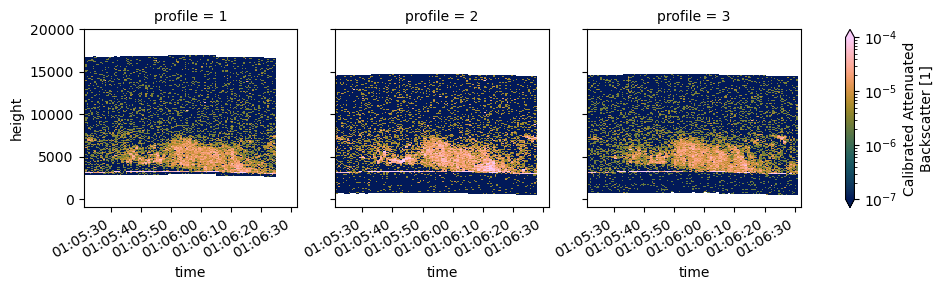

In [3]:
data_atl.cab_prof.plot(x='time',y='height', robust=True, col='profile', norm=colors.LogNorm(vmin=1e-7,vmax=1e-4,clip=True), cmap=cm.batlow)


## get data into right format for dda

This involves getting the data out of the data_atl variable in the right format.

In [4]:
# transpose the dataset into the right format
data_atl = data_atl.transpose('time_index', 'height', ...)
data_atl

<xarray.Dataset>
Dimensions:         (profile: 3, time_index: 1781, height: 700, layer: 10,
                     surface type: 5)
Coordinates:
  * profile         (profile) int64 1 2 3
  * time_index      (time_index) int64 0 1 2 3 4 5 ... 1776 1777 1778 1779 1780
  * height          (height) float32 2e+04 1.997e+04 1.994e+04 ... -925.5 -955.5
  * layer           (layer) int64 0 1 2 3 4 5 6 7 8 9
  * surface type    (surface type) int64 0 1 2 3 4
    d2s             (time_index, profile) float64 312.5 287.6 ... 218.5 243.6
    height_AGL      (time_index, height, profile) float64 1.691e+04 ... -3.89...
    time            (time_index, profile) datetime64[ns] 2021-02-11T01:05:14 ...
Data variables:
    cab_prof        (time_index, height, profile) float64 nan nan ... nan nan
    cloud_flag_atm  (time_index, profile) float64 0.0 0.0 1.0 ... 3.0 nan nan
    delta_time      (time_index, profile) float64 9.824e+07 9.824e+07 ... nan
    dem_h           (time_index, profile) float64 3.072e+03 3.105e+03 ... nan
    ds_va_bin_h     (height, profile) float64 2e+04 2e+04 ... -955.5 -955.5
    latitude        (time_index, profile) float64 69.8 70.03 70.25 ... nan nan
    layer_bot       (time_index, profile, layer) float64 nan nan nan ... nan nan
    layer_top       (time_index, profile, layer) float64 nan nan nan ... nan nan
    longitude       (time_index, profile) float64 -37.46 -37.46 ... nan nan
    surface_height  (time_index, profile) float64 3.092e+03 3.092e+03 ... nan
    cal_c           (time_index, profile) float64 8.204e+20 ... 8.633e+20

In [5]:
# start with profile 1
p = 1
data = data_atl.sel(profile=p).cab_prof.values
data[data < 0] = 0

heights = data_atl.height.values
dem = data_atl.sel(profile=p).dem_h.values

In [6]:
''' Template for kernal_args
kernal_args = {
    'sigma_y':,
    'dy':,
    'a_m': sigma_x/sigma_y
    'sigma_x':,
    'dx':,
    'cutoff':
    'n' -> superceeded by cutoff
    'm'
}'''
kernal_args = { # parameters given on pg134 of ATBD
    'sigma_y': 3,
    'a_m': 10,
    'cutoff': 1
}

In [7]:
kernal_args2 = {
    'sigma_y': 6,
    'a_m': 20,
    'cutoff': 1
}

In [8]:
density_args = {}

In [9]:
threshold_args = {
    'bias':2e-6,
    'sensitivity':1,
    'quantile':0.9,
    'segment_length':2
}

In [10]:
threshold_args2 = {
    'bias':2e-6,
    'sensitivity':1,
    'quantile':0.7,
    'segment_length':2
}

In [11]:
dda_args = {
    'data': data,
    'heights': heights,
    'dem': dem,
    'kernal_args': kernal_args, 'kernal_args2': kernal_args2,
    'density_args': density_args, 'density_args2': density_args,
    'threshold_args':threshold_args, 'threshold_args2':threshold_args2,
    'min_cluster_size':300,
    'remove_clusters_in_pass':False,
    'fill_clouds_with_noise':False,
    'dem_tol':3,
    'ground_width':5,
    'verbose':True
}

In [12]:
layers,density,thresholds,c_masks,ground,layer_masks = dda.dda_atl(**dda_args)

******** Starting pass 1
==== dda.steps.create_kernal.Gaussian()
==== dda.steps.calc_density()
==== dda.steps.calc_threshold()
Calculating thresholds.
===== dda.steps.calc_cloud_mask()
******** Starting pass 2
==== dda.steps.create_kernal.Gaussian()
==== dda.steps.calc_density()
==== dda.steps.calc_threshold()
Calculating thresholds.
===== dda.steps.calc_cloud_mask()
==== dda.steps.combine_masks
Removing small objects.
Small objects removed.
******** Finding ground signal
==== dda.steps.get_ground_bin()
Values flipped due to descending height order.
heights[0]=-955.4922
dem_bin.dtype=dtype('int64')
(dem_tol*dh)=89.9377326965332
np.max(ground_identified)=False
np.min(ground_identified)=False
Ground bins found,
ground_bin.dtype=dtype('int64')
==== dda.steps.combine_layers_from_mask_vectorized()
Performing up-pass.
Performing down-pass.
******** Removing ground from signal
==== dda.steps.remove_ground_from_mask()
==== dda.steps.combine_layers_from_mask_vectorized()
Performing up-pass.
Per

## Checking variables

In [13]:
time = data_atl.sel(profile=p).time.values

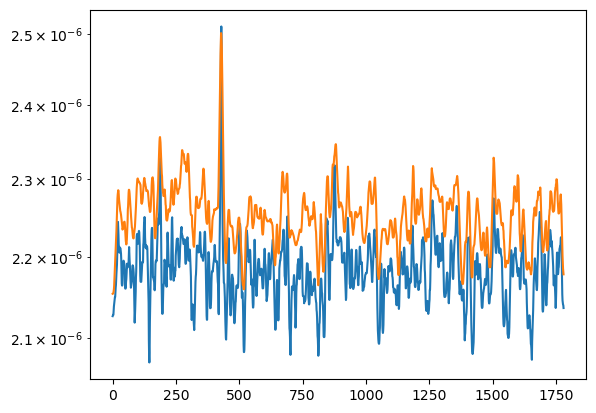

In [14]:
plt.plot(thresholds[0])
plt.plot(thresholds[1])
plt.gca().set_yscale('log')
plt.show()

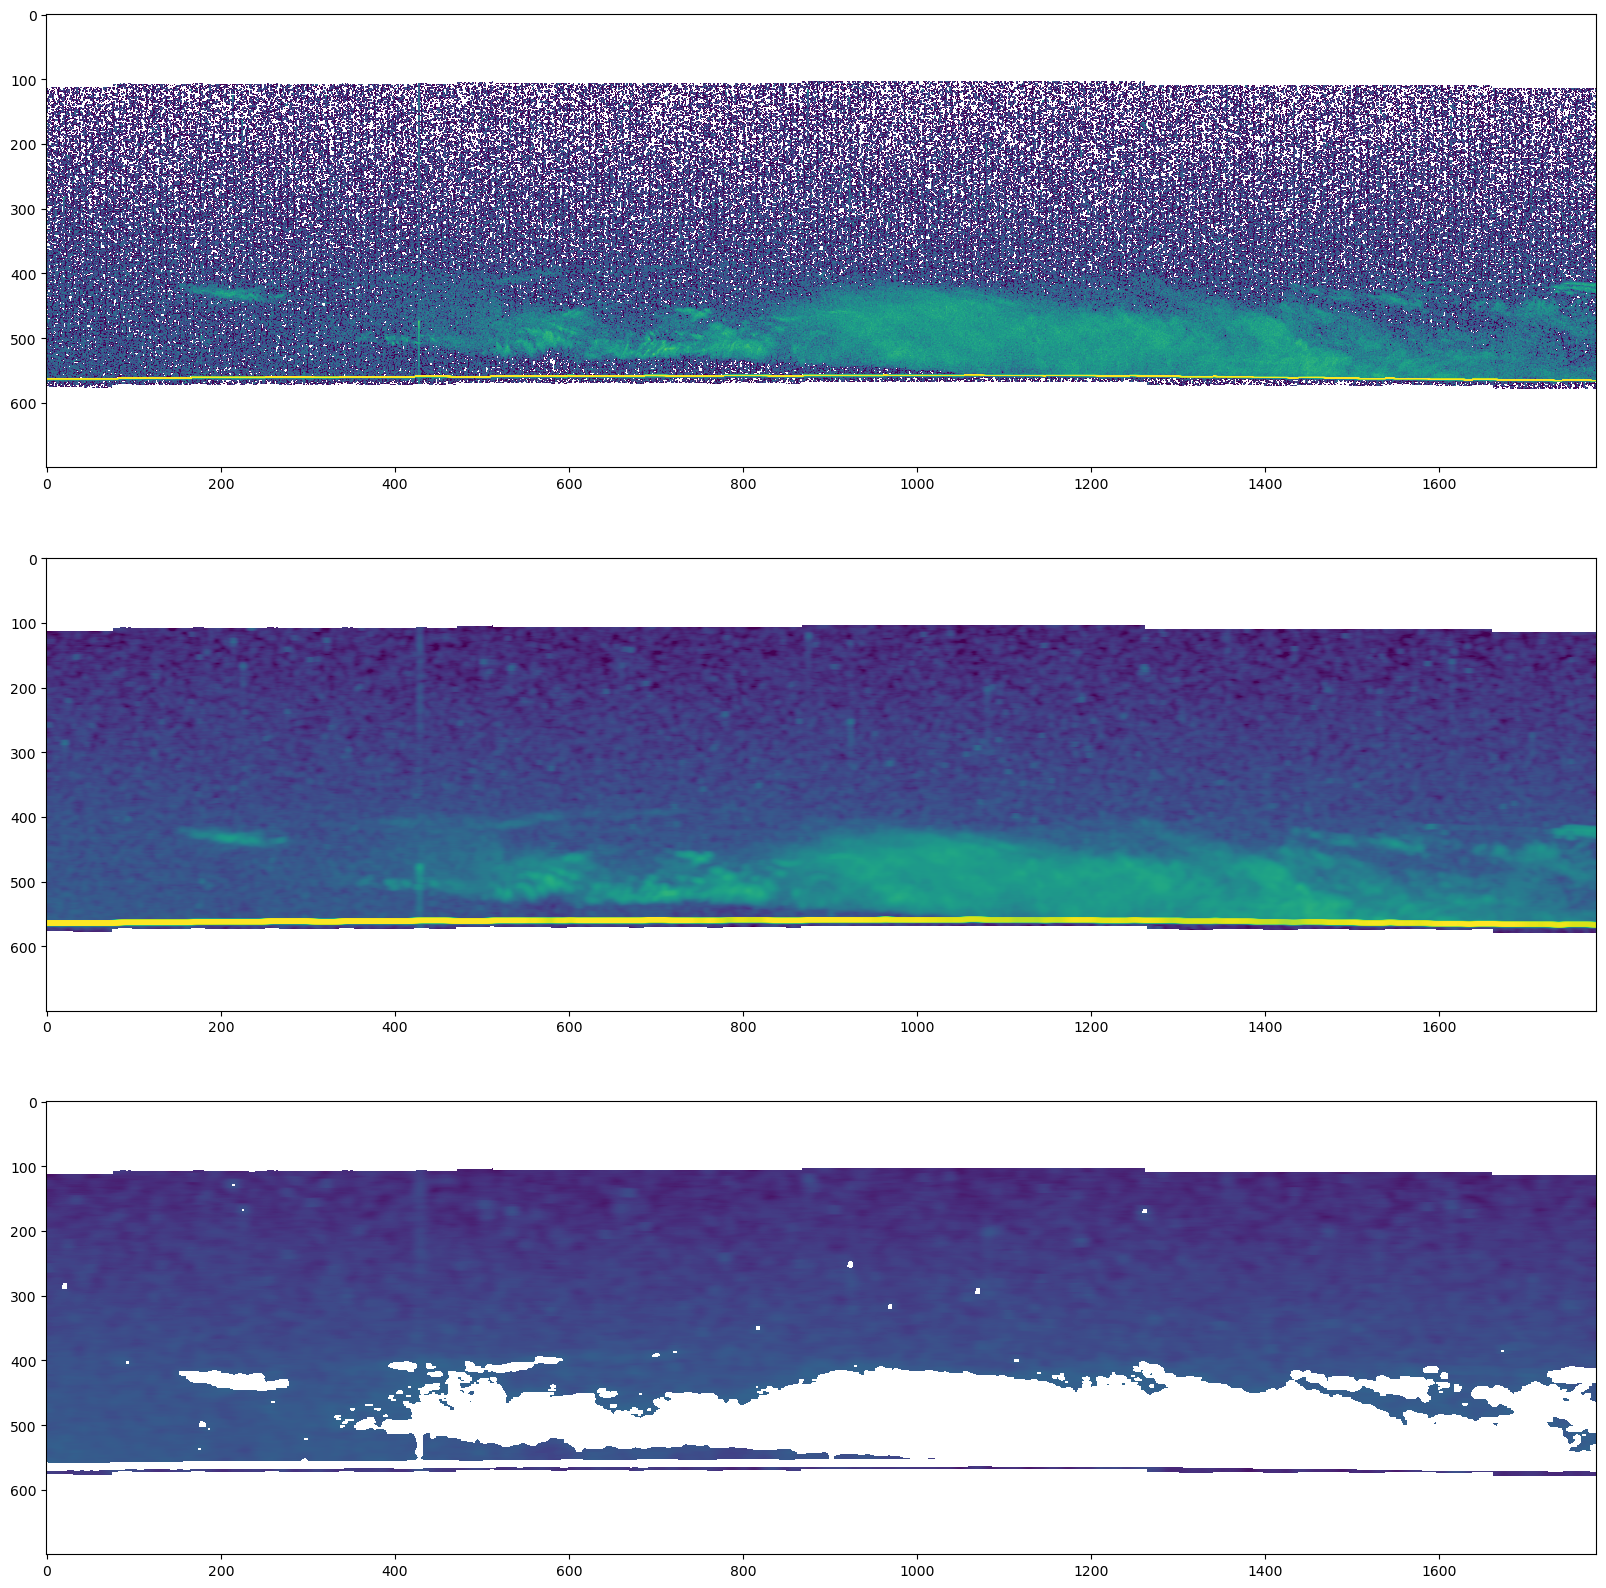

In [15]:
fig,axs = plt.subplots(3,1,figsize=(20,20))

axs[0].imshow(data.T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[1].imshow(density[0].T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[2].imshow(density[1].T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))

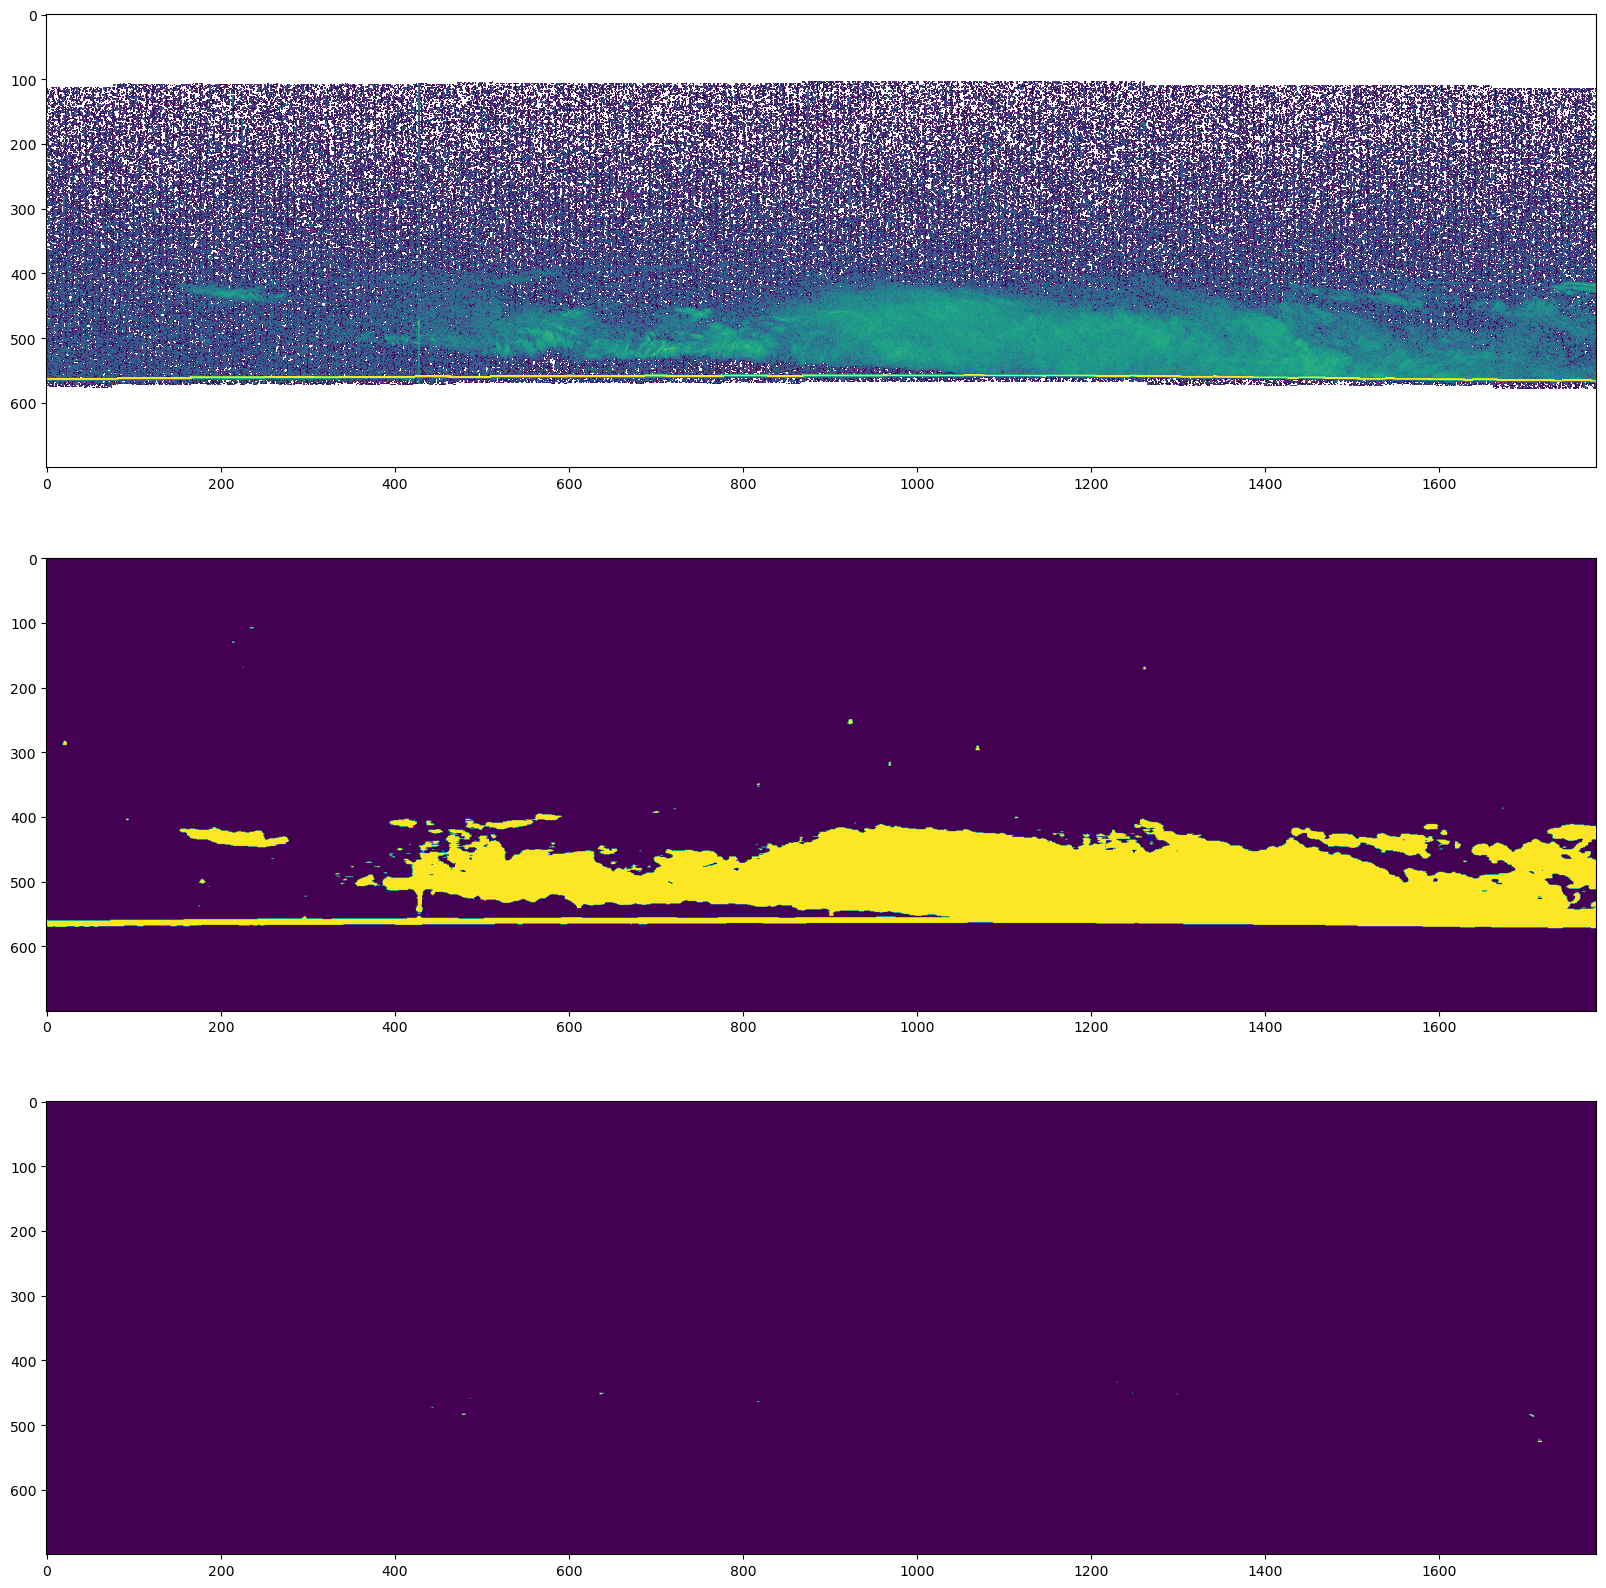

In [16]:
plt.close(fig)
fig,axs = plt.subplots(3,1,figsize=(20,20))

axs[0].imshow(data.T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[1].imshow(c_masks[0].T, aspect='auto')
axs[2].imshow(c_masks[1].T, aspect='auto')

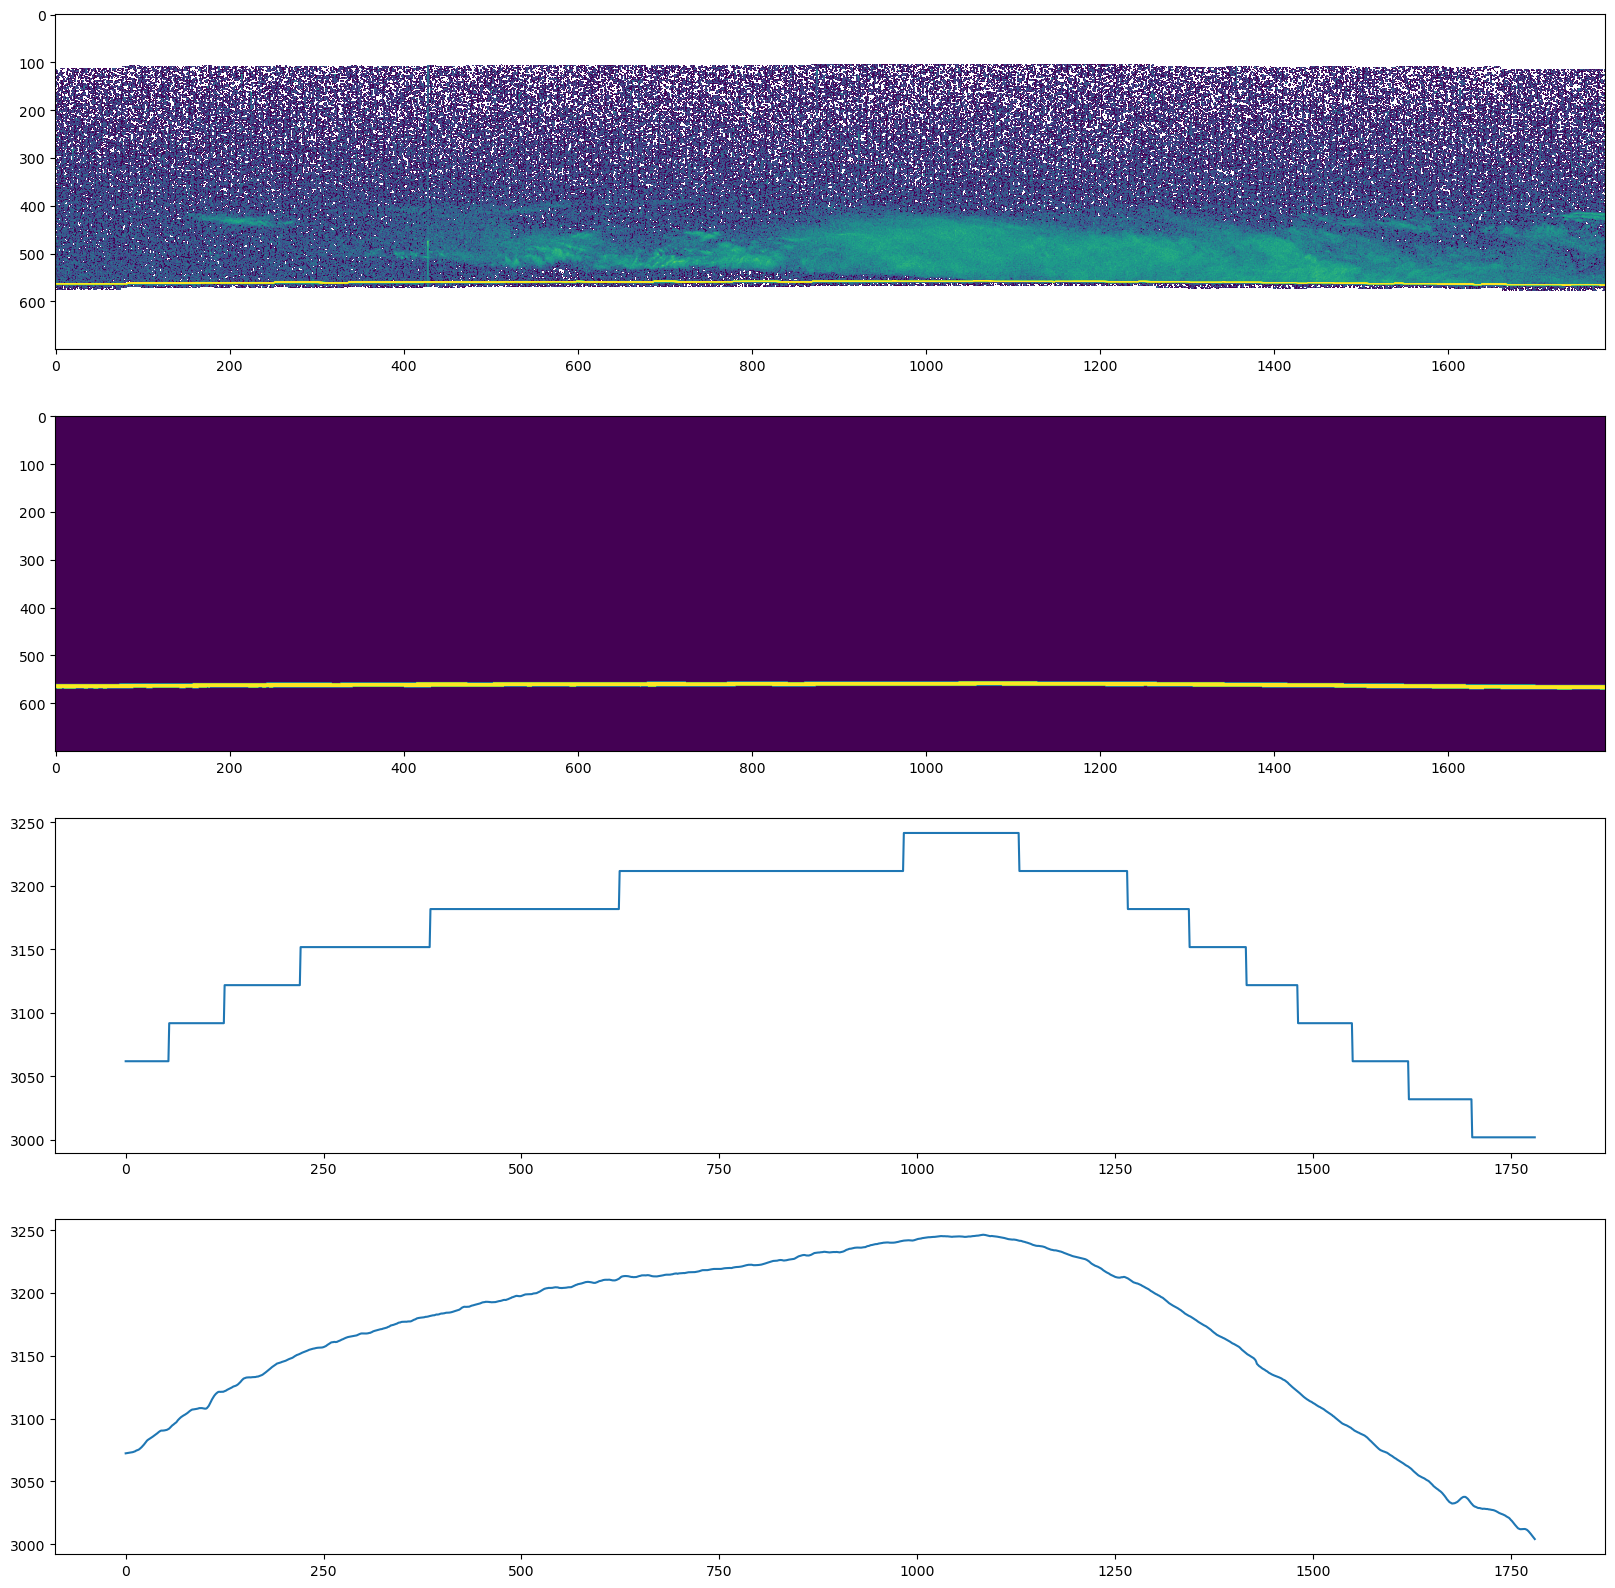

In [17]:
plt.close(fig)
fig,axs = plt.subplots(4,1,figsize=(20,20))

axs[0].imshow(data.T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3))
axs[1].imshow(ground[0].T, aspect='auto')
axs[2].plot(ground[1])
axs[3].plot(dem)

(1781,)
(1781, 1)


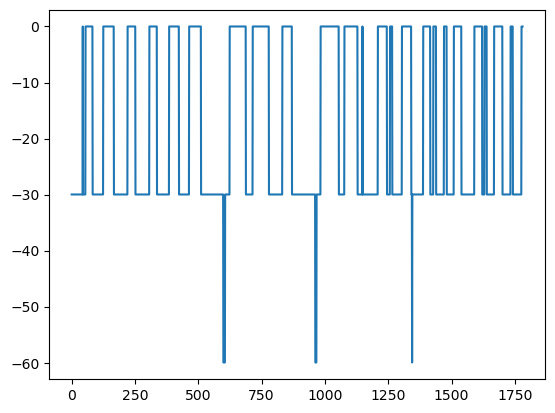

In [18]:
plt.close(fig)
surf_h = data_atl.sel(profile=p).surface_height.values
print(surf_h.shape)
print(ground[1].shape)
plt.plot(ground[1].squeeze()-surf_h)

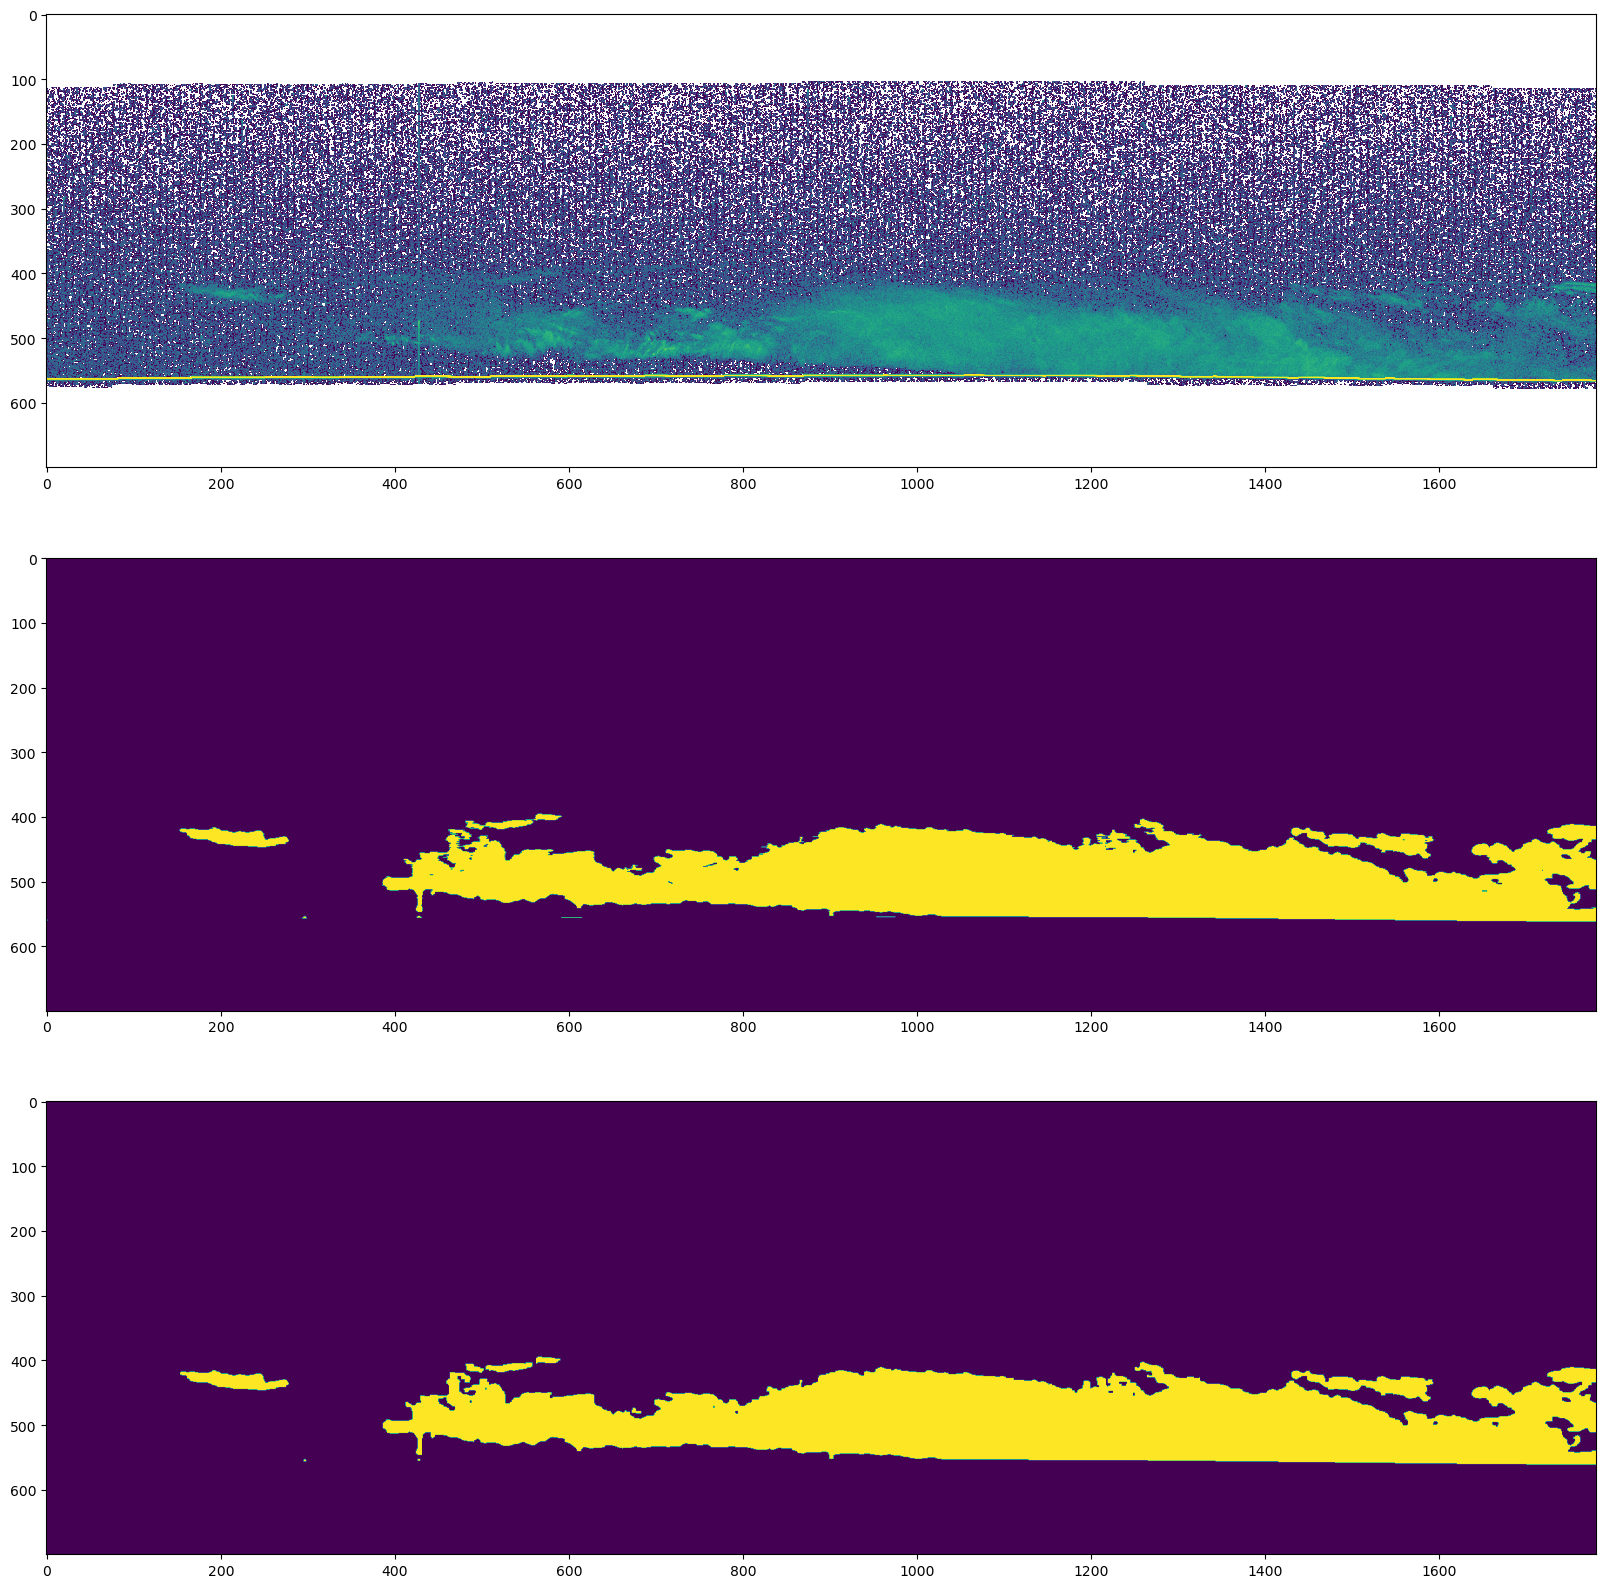

In [19]:
fig,axs = plt.subplots(3,1,figsize=(20,20))

axs[0].imshow(data.T, aspect='auto', norm=colors.LogNorm(vmin=1e-7,vmax=1e-3,clip=False))
axs[1].imshow(layer_masks[0].T, aspect='auto')
axs[2].imshow(layer_masks[1].T, aspect='auto')

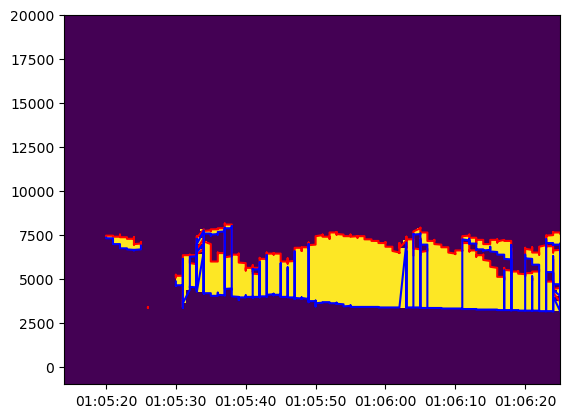

In [30]:
plt.close(fig)
y = heights
x = time
X,Y = np.meshgrid(x,y)

plt.pcolormesh(X,Y,layer_masks[1].T)
plt.plot(x,layers[2],c='r')
plt.plot(x,layers[1],c='b')


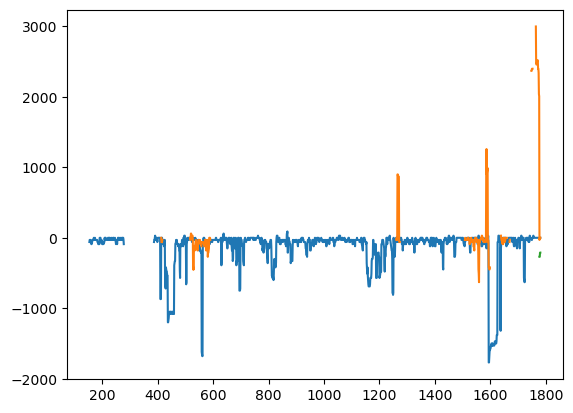

In [21]:
plt.plot(layers[2] - data_atl.sel(profile=p).layer_top.values)

## Speed testing

In [22]:
#raise NotImplementedError('Dont want to run.')

In [23]:
%%timeit
out1 = dda.steps.combine_layers_from_mask(layer_masks[0])

729 ms ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
out2 = dda.steps.combine_layers_from_mask_vectorized(layer_masks[0])

421 ms ± 63.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
out1 = dda.steps.combine_layers_from_mask(layer_masks[0])
out2 = dda.steps.combine_layers_from_mask_vectorized(layer_masks[0])

In [26]:
print(out1.shape,out2.shape)

(1781, 700) (1781, 700)


In [27]:
np.sum(out1 == out2)

1246700

In [28]:
np.sum(out1 != out2)

0